In [31]:
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
resp=pd.read_csv('/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/catPer_12345subTest10.txt', sep='\t', lineterminator='\n',header=None)
resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        10:"ButtonLeft",
        11:"ButtonRight"
        })

tableBench=resp.loc[resp['category'] == axis]
tableBench

,workerid,this_trial,Image,ImagePath,category,imageStart,imageEnd,response,responseTime,currentTime,ButtonLeft,ButtonRight
0,12345subTest10,0,13,./carchair_exp_3axes/tableBench_18_27.png,tableBench,1621726183770,1621726184774,1,1591,Sat May 22 2021 19:29:45 GMT-0400 (Eastern Day...,Table,Bench
1,12345subTest10,1,21,./carchair_exp_3axes/tableBench_58_9.png,tableBench,1621726185362,1621726186367,1,1670,Sat May 22 2021 19:29:47 GMT-0400 (Eastern Day...,Table,Bench
5,12345subTest10,5,13,./carchair_exp_3axes/tableBench_18_9.png,tableBench,1621726192172,1621726193173,2,1836,Sat May 22 2021 19:29:54 GMT-0400 (Eastern Day...,Bench,Table
6,12345subTest10,6,23,./carchair_exp_3axes/tableBench_66_27.png,tableBench,1621726194010,1621726195012,1,1485,Sat May 22 2021 19:29:55 GMT-0400 (Eastern Day...,Bench,Table
7,12345subTest10,7,20,./carchair_exp_3axes/tableBench_54_9.png,tableBench,1621726195497,1621726196499,2,2259,Sat May 22 2021 19:29:57 GMT-0400 (Eastern Day...,Bench,Table


KeyError: 13

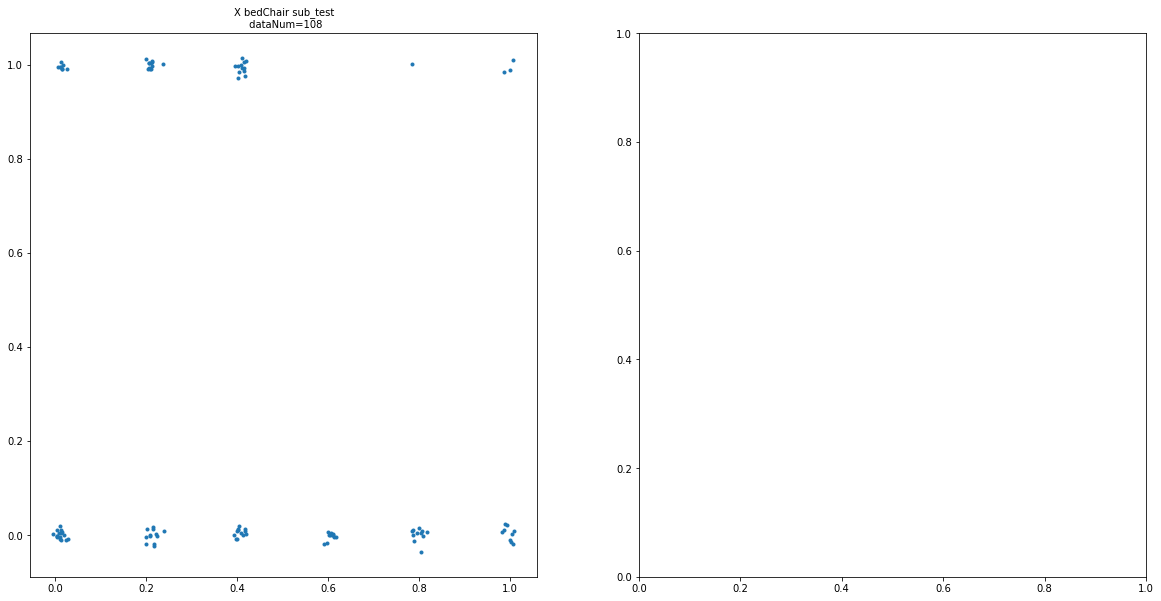

In [10]:
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def logit(subject,axis,ax,which_subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })

    tableBench=resp.loc[resp['category'] == axis]
    if len(tableBench)==0:
        return None,None,None,None
    _x=np.asarray(tableBench['Image'])
    X_dict={0:1,1:21,2:41,3:60,4:80,5:100,6:1,7:21,8:41,9:60,10:80,11:100}
    x=[]
    for _ in _x:
        x.append(X_dict[_])
    y=np.asarray(tableBench['response'])
    xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
    xy=xy[:,xy[0,:].argsort()]
    #xy[1,:]=2-xy[1,:]
    methodFlag="method1"
    if methodFlag=="method1":
        # method 1: use original datapoints for regression
        x=xy[0,:]
        y=xy[1,:]-1
        x=x/100
    else:
        # method 2: use frequency of choices for regression
        prob=[]
        for i in [1,21,41,60,80,100]:
            _prob=np.mean(xy[1,xy[0]==i])
            #print(xy[1,xy[0]==i])
            #print(_prob,end='\n\n')
            prob.append(_prob)
        x=np.asarray([1,21,41,60,80,100], dtype=np.float128)/100
        y=np.asarray(prob)-1
    
    morph1acc=round(np.mean(1-y[x==0.01]),3)
    morph21acc=round(np.mean(1-y[x==0.21]),3)
    morph80acc=round(np.mean(y[x==0.80]),3)
    morph100acc=round(np.mean(y[x==1]),3)
#     print("morph 1 acc=",morph1acc)
#     print("morph 21 acc=",morph21acc)
#     print("morph 80 acc=",morph80acc)
#     print("morph 100 acc=",morph100acc)
    if morph1acc>0.8 and morph100acc>0.8:
        title='✓ '
        exclusion="✓"
    else:
        title='X '
        exclusion="X"
    try: 
        def f(x, k, x0):
            return 1 / (1. + np.exp(-k * (x - x0)))
        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)
#         fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if methodFlag=="method1":
            _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        else:
            _=ax.plot(x,y, 'o')
        _=ax.plot(x_plot, y_fit, '-')

        if len(tableBench)==72:
            title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                             )
        else:
            title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                              len(tableBench)
                                             )
            exclusion='X'
            
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y
    except:
        title="X "
        exclusion="X"
        k,x0=None,None
        
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        if len(tableBench)==72:
            title=title+"{} sub_{}".format(axis,
                                           which_subject #(subject.split("_")[1]).split(".")[0],
                                             )
        else:
            title=title+"{} sub_{}\n dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              len(tableBench)
                                             )
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return (morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)


def checkVersion(subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })
    axes={'bedChair':'horizontal', 'benchBed':'vertical', 'chairBench':'diagonal'}
    for axis in ['bedChair', 'benchBed', 'chairBench']:
        data=resp.loc[resp['category'] == axis]
        if len(data)>0:
            return axes[axis]
    
    
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# os.chdir("/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/sub002/ses1/catPer")
# subject="catPer_000000sub002_1.txt"

# sub="sub002"
# ses="ses1"


# sub="sub001"
# ses="ses1"


# sub="sub002"
# ses="ses6"

# if ses=="ses6" or ses=="ses5":
#     catPerSession=2
# else:
#     catPerSession=1
# os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/{sub}/{ses}/catPer")
# subject=f"catPer_000000{sub}_{catPerSession}.txt"

os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/")
subject="catPer_123456subTest5.txt"


versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(1,2, figsize=(20, 10))
axis=versionDict[version][0]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0],"test")
axis=versionDict[version][1]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[1],"test")

#  9 grade design

/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


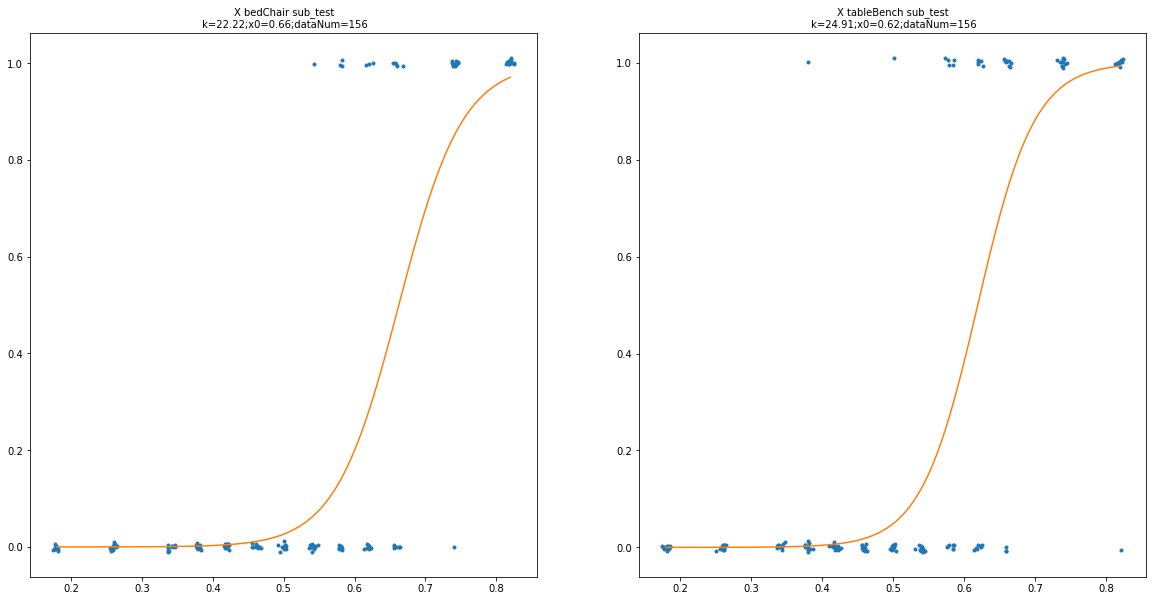

In [21]:
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def logit(subject,axis,ax,which_subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })

    tableBench=resp.loc[resp['category'] == axis]
    if len(tableBench)==0:
        return None,None,None,None
    _x=np.asarray(tableBench['Image'])
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    X_dict={0:18,1:26,2:34,3:38,4:42,5:46,6:50,7:54,8:58,9:62,10:66,11:74,12:82,13:18,14:26,15:34,16:38,17:42,18:46,19:50,20:54,21:58,22:62,23:66,24:74,25:82}
    x=[]
    for _ in _x:
        x.append(X_dict[_])
    y=np.asarray(tableBench['response'])
    xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
    xy=xy[:,xy[0,:].argsort()]
    #xy[1,:]=2-xy[1,:]
    methodFlag="method1"
    if methodFlag=="method1":
        # method 1: use original datapoints for regression
        x=xy[0,:]
        y=xy[1,:]-1
        x=x/100
    else:
        # method 2: use frequency of choices for regression
        prob=[]
        for i in [18, 26, 34, 42, 50, 58, 66, 74, 82]:
            _prob=np.mean(xy[1,xy[0]==i])
            #print(xy[1,xy[0]==i])
            #print(_prob,end='\n\n')
            prob.append(_prob)
        x=np.asarray([18, 26, 34, 42, 50, 58, 66, 74, 82], dtype=np.float128)/100
        y=np.asarray(prob)-1
    
    morph1acc=round(np.mean(1-y[x==0.01]),3)
    morph21acc=round(np.mean(1-y[x==0.21]),3)
    morph80acc=round(np.mean(y[x==0.80]),3)
    morph100acc=round(np.mean(y[x==1]),3)
#     print("morph 1 acc=",morph1acc)
#     print("morph 21 acc=",morph21acc)
#     print("morph 80 acc=",morph80acc)
#     print("morph 100 acc=",morph100acc)
    if morph1acc>0.8 and morph100acc>0.8:
        title='✓ '
        exclusion="✓"
    else:
        title='X '
        exclusion="X"
    try: 
        def f(x, k, x0):
            return 1 / (1. + np.exp(-k * (x - x0)))
        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)
#         fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if methodFlag=="method1":
            _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        else:
            _=ax.plot(x,y, 'o')
        _=ax.plot(x_plot, y_fit, '-')

        if len(tableBench)==72:
            title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                             )
        else:
            title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                              len(tableBench)
                                             )
            exclusion='X'
            
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y
    except:
        title="X "
        exclusion="X"
        k,x0=None,None
        
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        if len(tableBench)==72:
            title=title+"{} sub_{}".format(axis,
                                           which_subject #(subject.split("_")[1]).split(".")[0],
                                             )
        else:
            title=title+"{} sub_{}\n dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              len(tableBench)
                                             )
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return (morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)


def checkVersion(subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })
    axes={'bedChair':'horizontal', 'benchBed':'vertical', 'chairBench':'diagonal'}
    for axis in ['bedChair', 'benchBed', 'chairBench']:
        data=resp.loc[resp['category'] == axis]
        if len(data)>0:
            return axes[axis]
    
    
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# os.chdir("/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/sub002/ses1/catPer")
# subject="catPer_000000sub002_1.txt"

# sub="sub002"
# ses="ses1"


# sub="sub001"
# ses="ses1"


# sub="sub002"
# ses="ses6"

# if ses=="ses6" or ses=="ses5":
#     catPerSession=2
# else:
#     catPerSession=1
# os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/{sub}/{ses}/catPer")
# subject=f"catPer_000000{sub}_{catPerSession}.txt"

os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/")
# subject="catPer_123456subTest5.txt"
# subject="catPer_123456subTest6.txt"
# subject="catPer_123456sub0jeff.txt"
subject="catPer_123456subTest7.txt"


versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(1,2, figsize=(20, 10))
axis=versionDict[version][0]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0],"test")
axis=versionDict[version][1]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[1],"test")

# 13 design and random button

/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


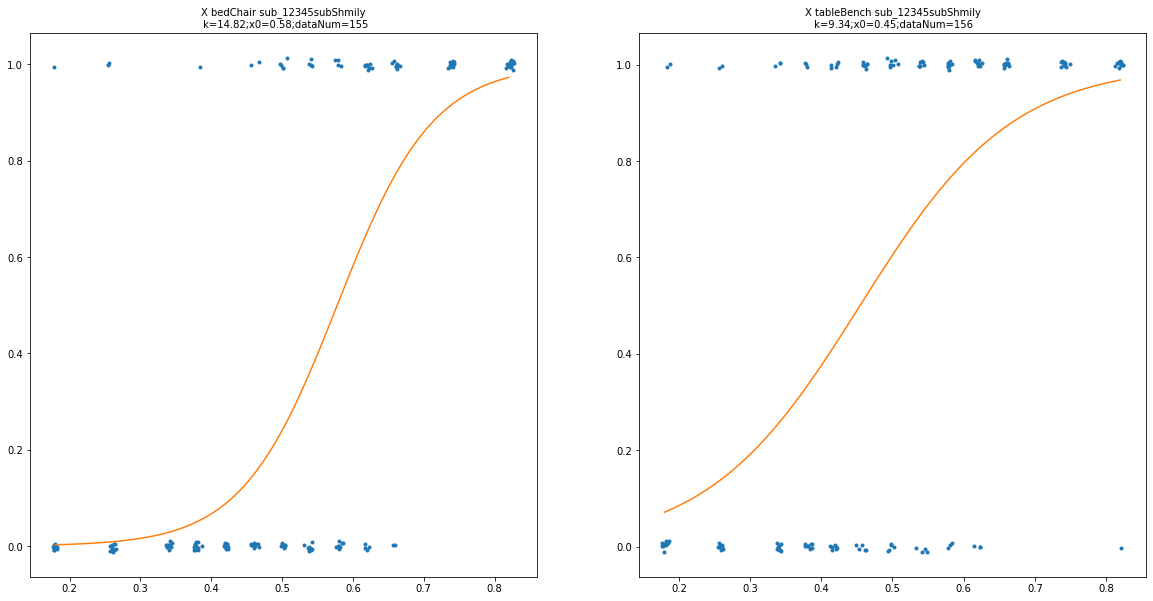

In [4]:

# design 13  and random button
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def logit(subject,axis,ax,which_subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        10:"ButtonLeft",
        11:"ButtonRight"
        })

    tableBench=resp.loc[resp['category'] == axis]
    if len(tableBench)==0:
        return None,None,None,None
    _x=np.asarray(tableBench['Image'])
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    X_dict={0:18,1:26,2:34,3:38,4:42,5:46,6:50,7:54,8:58,9:62,10:66,11:74,12:82,13:18,14:26,15:34,16:38,17:42,18:46,19:50,20:54,21:58,22:62,23:66,24:74,25:82}
    x=[]
    for _ in _x:
        x.append(X_dict[_])
    y=np.asarray(tableBench['response'])
    # according to whether bottonLeft is Bed or Table, resave the response
    y_=[]
    if 'bed' in axis:
        button_good=list(tableBench['ButtonLeft']=="Bed")
    else:
        button_good=list(tableBench['ButtonLeft']=="Table")
    for i,j in enumerate(button_good):
        if j:
            y_.append(y[i])
        else:
            if y[i]==1:
                y_.append(2)
            else:
                y_.append(1)
    y=np.asarray(y_)

    xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
    xy=xy[:,xy[0,:].argsort()]
    #xy[1,:]=2-xy[1,:]
    methodFlag="method1"
    if methodFlag=="method1":
        # method 1: use original datapoints for regression
        x=xy[0,:]
        y=xy[1,:]-1
        x=x/100
    else:
        # method 2: use frequency of choices for regression
        pass
        # prob=[]
        # for i in [18, 26, 34, 42, 50, 58, 66, 74, 82]:
        #     _prob=np.mean(xy[1,xy[0]==i])
        #     #print(xy[1,xy[0]==i])
        #     #print(_prob,end='\n\n')
        #     prob.append(_prob)
        # x=np.asarray([18, 26, 34, 42, 50, 58, 66, 74, 82], dtype=np.float128)/100
        # y=np.asarray(prob)-1
    
    morph1acc=round(np.mean(1-y[x==0.01]),3)
    morph21acc=round(np.mean(1-y[x==0.21]),3)
    morph80acc=round(np.mean(y[x==0.80]),3)
    morph100acc=round(np.mean(y[x==1]),3)
    # print("morph 1 acc=",morph1acc)
    # print("morph 21 acc=",morph21acc)
    # print("morph 80 acc=",morph80acc)
    # print("morph 100 acc=",morph100acc)
    if morph1acc>0.8 and morph100acc>0.8:
        title='✓ '
        exclusion="✓"
    else:
        title='X '
        exclusion="X"
    try: 
        def f(x, k, x0):
            return 1 / (1. + np.exp(-k * (x - x0)))
        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)
        # fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if methodFlag=="method1":
            _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        else:
            _=ax.plot(x,y, 'o')
        _=ax.plot(x_plot, y_fit, '-')

        if len(tableBench)==72:
            title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                             )
        else:
            title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                              len(tableBench)
                                             )
            exclusion='X'
            
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y
    except:
        title="X "
        exclusion="X"
        k,x0=None,None
        
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        if len(tableBench)==72:
            title=title+"{} sub_{}".format(axis,
                                           which_subject #(subject.split("_")[1]).split(".")[0],
                                             )
        else:
            title=title+"{} sub_{}\n dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              len(tableBench)
                                             )
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return (morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)


def checkVersion(subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })
    axes={'bedChair':'horizontal', 'benchBed':'vertical', 'chairBench':'diagonal'}
    for axis in ['bedChair', 'benchBed', 'chairBench']:
        data=resp.loc[resp['category'] == axis]
        if len(data)>0:
            return axes[axis]
    
    
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# os.chdir("/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/sub002/ses1/catPer")
# subject="catPer_000000sub002_1.txt"

# sub="sub002"
# ses="ses1"


# sub="sub001"
# ses="ses1"


# sub="sub002"
# ses="ses6"

# if ses=="ses6" or ses=="ses5":
#     catPerSession=2
# else:
#     catPerSession=1
# os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/{sub}/{ses}/catPer")
# subject=f"catPer_000000{sub}_{catPerSession}.txt"

os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/")
# subject="catPer_123456subTest5.txt"
# subject="catPer_123456subTest6.txt"
# subject="catPer_123456sub0jeff.txt"
# subject="catPer_123456subTest7.txt"
sub="12345subShmily" #12345subTest11 12345subShmily
subject=f"catPer_{sub}.txt"


versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(1,2, figsize=(20, 10))
axis=versionDict[version][0]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0],sub)
axis=versionDict[version][1]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[1],sub)



In [3]:
!ls

catPer_ 12345subShmily.txt catPer_123456subTest7.txt
catPer_123456sub0jeff.txt  catPer_123456subTest9.txt
catPer_123456subTest5.txt  catPer_12345subTest10.txt
catPer_123456subTest6.txt  catPer_12345subTest11.txt


/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


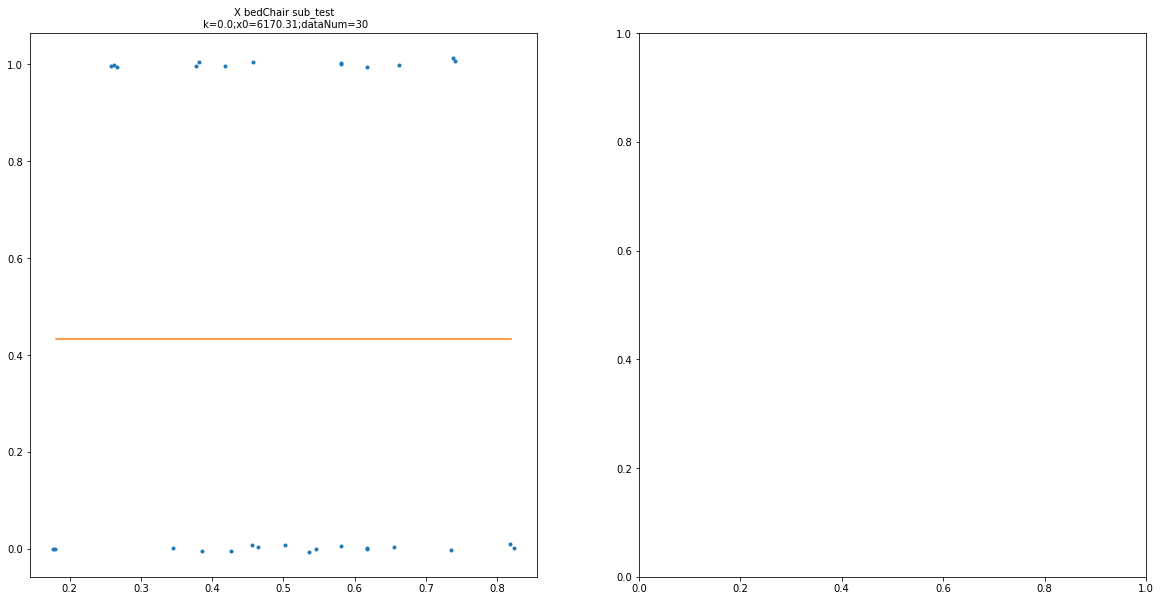

In [54]:

os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/")
# subject="catPer_123456subTest5.txt"
# subject="catPer_123456subTest6.txt"
# subject="catPer_123456sub0jeff.txt"
# subject="catPer_123456subTest7.txt"
subject="catPer_12345subTest10.txt"


versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(1,2, figsize=(20, 10))
axis=versionDict[version][0]

# logit(subject,axis,ax[0],"test")
subject,axis,ax,which_subject=subject,axis,ax[0],"test"
resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
resp=resp.rename(columns={
    0:"workerid",
    1:"this_trial",
    2:"Image",
    3:"ImagePath",
    4:"category",
    5:"imageStart",
    6:"imageEnd",
    7:"response",
    8:"responseTime",
    9:"currentTime",
    10:"ButtonLeft",
    11:"ButtonRight"
    })
resp
tableBench=resp.loc[resp['category'] == axis]

_x=np.asarray(tableBench['Image'])
X_dict={0:18,1:26,2:34,3:38,4:42,5:46,6:50,7:54,8:58,9:62,10:66,11:74,12:82,13:18,14:26,15:34,16:38,17:42,18:46,19:50,20:54,21:58,22:62,23:66,24:74,25:82}
x=[]
for _ in _x:
    x.append(X_dict[_])
y=np.asarray(tableBench['response'])
y_=[]
if 'bed' in axis:
    button_good=list(tableBench['ButtonLeft']=="Bed")
else:
    button_good=list(tableBench['ButtonLeft']=="Table")
for i,j in enumerate(button_good):
    if j:
        y_.append(y[i])
    else:
        if y[i]==1:
            y_.append(1)
        else:
            y_.append(2)
y=np.asarray(y_)

xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
xy=xy[:,xy[0,:].argsort()]
#xy[1,:]=2-xy[1,:]
methodFlag="method1"
if methodFlag=="method1":
    # method 1: use original datapoints for regression
    x=xy[0,:]
    y=xy[1,:]-1
    x=x/100
else:
    # method 2: use frequency of choices for regression
    pass
#         prob=[]
#         for i in [18, 26, 34, 42, 50, 58, 66, 74, 82]:
#             _prob=np.mean(xy[1,xy[0]==i])
#             #print(xy[1,xy[0]==i])
#             #print(_prob,end='\n\n')
#             prob.append(_prob)
#         x=np.asarray([18, 26, 34, 42, 50, 58, 66, 74, 82], dtype=np.float128)/100
#         y=np.asarray(prob)-1

morph1acc=round(np.mean(1-y[x==0.01]),3)
morph21acc=round(np.mean(1-y[x==0.21]),3)
morph80acc=round(np.mean(y[x==0.80]),3)
morph100acc=round(np.mean(y[x==1]),3)
#     print("morph 1 acc=",morph1acc)
#     print("morph 21 acc=",morph21acc)
#     print("morph 80 acc=",morph80acc)
#     print("morph 100 acc=",morph100acc)
if morph1acc>0.8 and morph100acc>0.8:
    title='✓ '
    exclusion="✓"
else:
    title='X '
    exclusion="X"
try: 
    def f(x, k, x0):
        return 1 / (1. + np.exp(-k * (x - x0)))
    # fit and plot the curve
    (k,x0), _ = opt.curve_fit(f, x, y)
    n_plot=100
    x_plot = np.linspace(min(x), max(x), n_plot)
    y_fit = f(x_plot, k,x0)
#         fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    if methodFlag=="method1":
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
    else:
        _=ax.plot(x,y, 'o')
    _=ax.plot(x_plot, y_fit, '-')

    if len(tableBench)==72:
        title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                          which_subject, #(subject.split("_")[1]).split(".")[0],
                                          round(k, 2),
                                          round(x0, 2),
                                         )
    else:
        title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                          which_subject, #(subject.split("_")[1]).split(".")[0],
                                          round(k, 2),
                                          round(x0, 2),
                                          len(tableBench)
                                         )
        exclusion='X'

    _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})

except:
    pass

/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


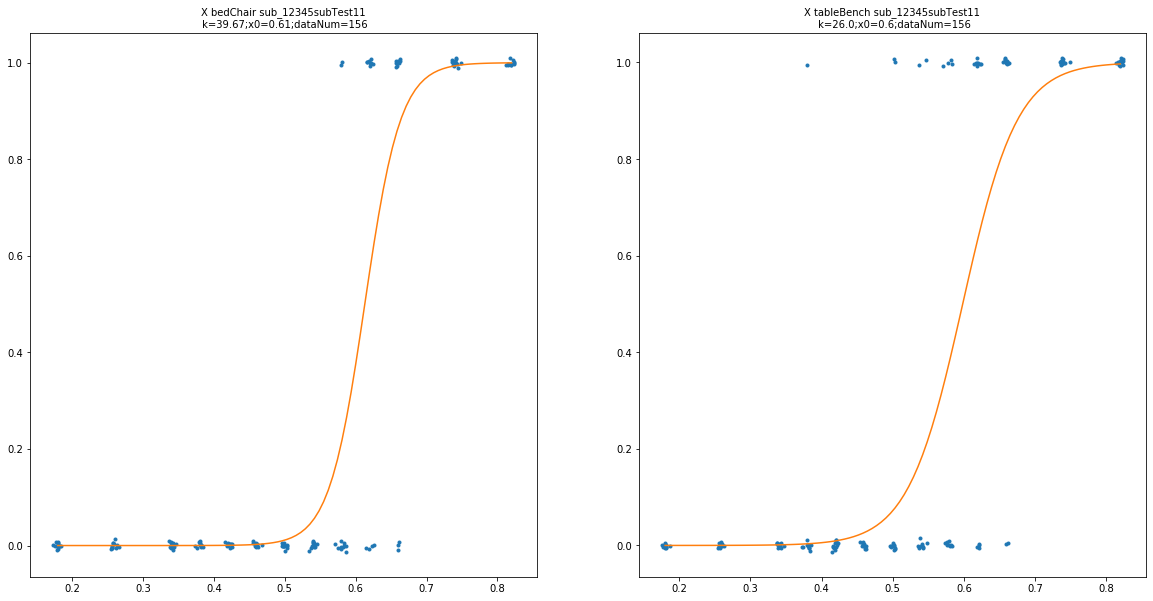

In [61]:

# design 13  and random button
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def logit(subject,axis,ax,which_subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        10:"ButtonLeft",
        11:"ButtonRight"
        })

    tableBench=resp.loc[resp['category'] == axis]
    if len(tableBench)==0:
        return None,None,None,None
    _x=np.asarray(tableBench['Image'])
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    X_dict={0:18,1:26,2:34,3:38,4:42,5:46,6:50,7:54,8:58,9:62,10:66,11:74,12:82,13:18,14:26,15:34,16:38,17:42,18:46,19:50,20:54,21:58,22:62,23:66,24:74,25:82}
    x=[]
    for _ in _x:
        x.append(X_dict[_])
    y=np.asarray(tableBench['response'])
    # according to whether bottonLeft is Bed or Table, resave the response
    y_=[]
    if 'bed' in axis:
        button_good=list(tableBench['ButtonLeft']=="Bed")
    else:
        button_good=list(tableBench['ButtonLeft']=="Table")
    for i,j in enumerate(button_good):
        if j:
            y_.append(y[i])
        else:
            if y[i]==1:
                y_.append(2)
            else:
                y_.append(1)
    y=np.asarray(y_)

    xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
    xy=xy[:,xy[0,:].argsort()]
    #xy[1,:]=2-xy[1,:]
    methodFlag="method1"
    if methodFlag=="method1":
        # method 1: use original datapoints for regression
        x=xy[0,:]
        y=xy[1,:]-1
        x=x/100
    else:
        # method 2: use frequency of choices for regression
        pass
        # prob=[]
        # for i in [18, 26, 34, 42, 50, 58, 66, 74, 82]:
        #     _prob=np.mean(xy[1,xy[0]==i])
        #     #print(xy[1,xy[0]==i])
        #     #print(_prob,end='\n\n')
        #     prob.append(_prob)
        # x=np.asarray([18, 26, 34, 42, 50, 58, 66, 74, 82], dtype=np.float128)/100
        # y=np.asarray(prob)-1
    
    morph1acc=round(np.mean(1-y[x==0.01]),3)
    morph21acc=round(np.mean(1-y[x==0.21]),3)
    morph80acc=round(np.mean(y[x==0.80]),3)
    morph100acc=round(np.mean(y[x==1]),3)
    # print("morph 1 acc=",morph1acc)
    # print("morph 21 acc=",morph21acc)
    # print("morph 80 acc=",morph80acc)
    # print("morph 100 acc=",morph100acc)
    if morph1acc>0.8 and morph100acc>0.8:
        title='✓ '
        exclusion="✓"
    else:
        title='X '
        exclusion="X"
    try: 
        def f(x, k, x0):
            return 1 / (1. + np.exp(-k * (x - x0)))
        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)
        # fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if methodFlag=="method1":
            _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        else:
            _=ax.plot(x,y, 'o')
        _=ax.plot(x_plot, y_fit, '-')

        if len(tableBench)==72:
            title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                             )
        else:
            title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                              len(tableBench)
                                             )
            exclusion='X'
            
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y
    except:
        title="X "
        exclusion="X"
        k,x0=None,None
        
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        if len(tableBench)==72:
            title=title+"{} sub_{}".format(axis,
                                           which_subject #(subject.split("_")[1]).split(".")[0],
                                             )
        else:
            title=title+"{} sub_{}\n dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              len(tableBench)
                                             )
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return (morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)


def checkVersion(subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })
    axes={'bedChair':'horizontal', 'benchBed':'vertical', 'chairBench':'diagonal'}
    for axis in ['bedChair', 'benchBed', 'chairBench']:
        data=resp.loc[resp['category'] == axis]
        if len(data)>0:
            return axes[axis]
    
    
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# os.chdir("/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/sub002/ses1/catPer")
# subject="catPer_000000sub002_1.txt"

# sub="sub002"
# ses="ses1"


# sub="sub001"
# ses="ses1"


# sub="sub002"
# ses="ses6"

# if ses=="ses6" or ses=="ses5":
#     catPerSession=2
# else:
#     catPerSession=1
# os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/{sub}/{ses}/catPer")
# subject=f"catPer_000000{sub}_{catPerSession}.txt"

os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/")
# subject="catPer_123456subTest5.txt"
# subject="catPer_123456subTest6.txt"
# subject="catPer_123456sub0jeff.txt"
# subject="catPer_123456subTest7.txt"
sub="12345subTest11"
subject=f"catPer_{sub}.txt"


versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(1,2, figsize=(20, 10))
axis=versionDict[version][0]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0],sub)
axis=versionDict[version][1]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[1],sub)



(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([18.  , 18.64, 19.28, 19.92, 20.56, 21.2 , 21.84, 22.48, 23.12,
        23.76, 24.4 , 25.04, 25.68, 26.32, 26.96, 27.6 , 28.24, 28.88,
        29.52, 30.16, 30.8 , 31.44, 32.08, 32.72, 33.36, 34.  , 34.64,
        35.28, 35.92, 36.56, 37.2 , 37.84, 38.48, 39.12, 39.76, 40.4 ,
        41.04, 41.68, 42.32, 42.96, 43.6 , 44.24, 44.88, 45.52, 46.16,
        46.8 , 47.44, 48.08, 48.72, 49.36, 50.  , 50.64, 51.28, 51.92,
        52.56, 53.2 , 53.84, 54.48, 55.12, 55.76, 56.4 , 57.04, 57.68,
        58.32, 58.96, 59.6 , 60.24, 60.88, 61.52, 62.

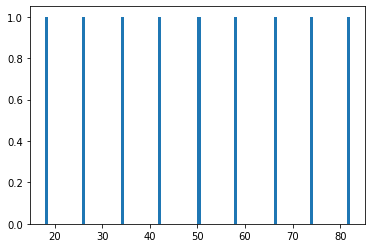

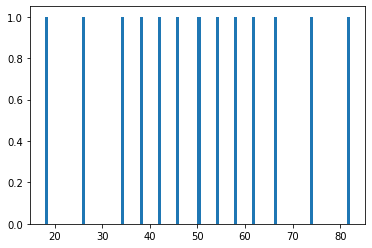

In [18]:
# plt.hist([18,26,34,42,50,58,66,74,82],bins=100)
# plt.figure()
# plt.hist([18,26,34,38,42,46,50,54,58,62,66,74,82],bins=100)

# write python code to write html code

In [9]:
## version one
# import os
# os.chdir("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtSynth_repo/kp_scratch/expcode/")

# import urllib.request
# import numpy as np
# from tqdm import tqdm
# # select output dir
# outdir = './carchair_exp_demo_rotating/'
# stride = 1

# cats = ['furniture']
# furn = ['bedChair', 'tableBench']
# veh = [] 
# viewpoints = np.arange(0, 40, 1) #np.arange(5, 40, 1) #np.array([5]) #np.arange(3, 40, 3) #np.array([4,5,6,15,25,35]) #np.arange(0, 40, stride) 0-39 #np.arange(3, 40, 3)
# morphList = np.array([1, 100]) #np.arange(1,100) #np.array([  1,  21,  41,  60,  80, 100])
# morphs = [morphList] #[np.arange(1,101, stride), np.arange(10,100,stride)]
# blendDict = dict(zip(cats, morphs))
# axisDict = dict(zip(cats, [furn]))
# urlstem = "https://s3.amazonaws.com/morphrecog-images-1/{}_{}_{}.png.png"
# # https://s3.amazonaws.com/morphrecog-images-1/bedChair_21_21.png.png

# L=[]
# curr_demo_ID=0
# for cat in cats:
#     blends = blendDict[cat]
#     axes = axisDict[cat]
#     for axis in axes[:]:
#         for blend in tqdm(blends[:]):
#             for view in viewpoints[:]:
#                 #print(urlstem.format(axis, blend, view))
#                 temp="carchair_exp_demo_rotating/{}_{}_{}.png".format(axis, blend, view)

#                 print("<img id='stimuli_{}' class='stimuli' src='{}'>".format(curr_demo_ID,temp))
#                 curr_demo_ID=curr_demo_ID+1


                
# version carchair_exp_3axes_demo_rotating       

currFurSpaceDirection="diagonal" # "horizontal" "vertical" "diagonal"

axes = {
  "horizontal": ["bedChair", "tableBench"],
  "vertical": ["benchBed","chairTable"],
  "diagonal": ["chairBench","bedTable"]
};
buttons = {
  "horizontal": [{"left":"Bed","right":"Chair"},{"left":"Table","right":"Bench"}],
  "vertical": [{"left":"Bench","right":"Bed"},{"left":"Chair","right":"Table"}],
  "diagonal": [{"left":"Chair","right":"Bench"},{"left":"Bed","right":"Table"}]
};

import os
os.chdir("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtSynth_repo/kp_scratch/expcode/")

import urllib.request
import numpy as np
from tqdm import tqdm
# select output dir
outdir = "./carchair_exp_3axes_demo_rotating/"
if not os.path.isdir(outdir):
    os.mkdir(outdir)
stride = 1

cats = ['furniture']
furn = axes[currFurSpaceDirection] #['bedChair', 'tableBench']
veh = [] 
viewpoints = np.arange(0, 40, 1) #np.arange(5, 40, 1) #np.array([5]) #np.arange(3, 40, 3) #np.array([4,5,6,15,25,35]) #np.arange(0, 40, stride) 0-39 #np.arange(3, 40, 3)
morphList = np.array([1, 100]) #np.arange(1,100) #np.array([  1,  21,  41,  60,  80, 100])
morphs = [morphList] #[np.arange(1,101, stride), np.arange(10,100,stride)]
blendDict = dict(zip(cats, morphs))
axisDict = dict(zip(cats, [furn]))
urlstem = "https://s3.amazonaws.com/morphrecog-images-1/{}_{}_{}.png.png"
# https://s3.amazonaws.com/morphrecog-images-1/bedChair_21_21.png.png

L=[]
curr_demo_ID=0
for cat in cats:
    blends = blendDict[cat]
    axes = axisDict[cat]
    for axis in axes[:]:
        for blend in tqdm(blends[:]):
            for view in viewpoints[:]:
                #print(urlstem.format(axis, blend, view))
                temp="carchair_exp_demo_rotating/{}_{}_{}.png".format(axis, blend, view)

                print("<img id='stimuli_{}' class='stimuli' src='{}'>".format(curr_demo_ID,temp))
                curr_demo_ID=curr_demo_ID+1

100%|██████████| 2/2 [00:00<00:00, 675.90it/s]

<img id='stimuli_0' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_0.png'>
<img id='stimuli_1' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_1.png'>
<img id='stimuli_2' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_2.png'>
<img id='stimuli_3' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_3.png'>
<img id='stimuli_4' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_4.png'>
<img id='stimuli_5' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_5.png'>
<img id='stimuli_6' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_6.png'>
<img id='stimuli_7' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_7.png'>
<img id='stimuli_8' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_8.png'>
<img id='stimuli_9' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_9.png'>
<img id='stimuli_10' class='stimuli' src='carchair_exp_demo_rotating/chairBench_1_10.png'>
<img id='stimuli_11

In [35]:

# import pandas as pd
# import os
# import numpy as np
# import scipy.optimize as opt
# import matplotlib.pyplot as plt
# %matplotlib inline
# os.chdir("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/realtime/javascript/data/")

# resp=pd.read_csv('./catPer_O7JER.txt', sep='\t', lineterminator='\n',header=None)
# resp=resp.rename(columns={
#     0:"workerid",
#     1:"this_trial",
#     2:"Image",
#     3:"ImagePath",
#     4:"category",
#     5:"imageStart",
#     6:"imageEnd",
#     7:"response",
#     8:"responseTime",
#     9:"currentTime",
#     })
# # for i in range(len(resp)):
# #     print(resp.iloc[i])
# #     print("\n\n")
# # # df['imageEnd']-df['imageStart']

workerid                                                    O7JER
this_trial                                                      0
Image                                                           1
ImagePath                       ./carchair_exp/bedChair_21_27.png
category                                                 bedChair
imageStart                                          1588577331915
imageEnd                                            1588577332919
response                                                        1
responseTime                                                12727
currentTime     Mon May 04 2020 00:29:04 GMT-0700 (Pacific Day...
Name: 0, dtype: object



workerid                                                    O7JER
this_trial                                                      1
Image                                                           0
ImagePath                        ./carchair_exp/bedChair_1_15.png
category                                          

Name: 136, dtype: object



workerid                                                    O7JER
this_trial                                                    137
Image                                                           2
ImagePath                        ./carchair_exp/bedChair_41_3.png
category                                                 bedChair
imageStart                                          1588577591237
imageEnd                                            1588577592240
response                                                        1
responseTime                                                 1670
currentTime     Mon May 04 2020 00:33:12 GMT-0700 (Pacific Day...
Name: 137, dtype: object



workerid                                                    O7JER
this_trial                                                    138
Image                                                          11
ImagePath                    ./carchair_exp/tableBench_100_12.png
category            

k= -12.595997050123815
x0= 0.5224639443842366


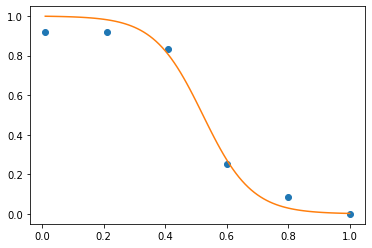

In [56]:

# def f(x, k, x0):
#     return 1 / (1. + np.exp(-k * (x - x0)))

# #tableBench axis
# tableBench=resp.loc[resp['category'] == 'tableBench']
# _x=np.asarray(tableBench['Image'])
# X_dict={0:1,1:21,2:41,3:60,4:80,5:100,6:1,7:21,8:41,9:60,10:80,11:100}
# x=[]
# for _ in _x:
#     x.append(X_dict[_])

# y=np.asarray(tableBench['response'])
# xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
# xy=xy[:,xy[0,:].argsort()]
# xy[1,:]=2-xy[1,:]

# # method 1: use original datapoints for regression
# # x=xy[0,:]
# # y=xy[1,:]
# # x=x/100

# # method 2: use frequency of choices for regression
# prob=[]
# for i in [1,21,41,60,80,100]:
#     _prob=np.mean(xy[1,xy[0]==i])
#     prob.append(_prob)
# x=np.asarray([1,21,41,60,80,100], dtype=np.float128)/100
# y=np.asarray(prob)

# # fit and plot the curve
# (k,x0), _ = opt.curve_fit(f, x, y)
# print('k=',k)
# print('x0=',x0)
# n_plot=100
# x_plot = np.linspace(min(x), max(x), n_plot)
# y_fit = f(x_plot, k,x0)
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# _=ax.plot(x, y, 'o')
# _=ax.plot(x_plot, y_fit, '-')

In [456]:
# # tableBench[tableBench['Image'] == 11]['response']

# import pandas as pd
# import os
# import numpy as np
# import scipy.optimize as opt
# import matplotlib.pyplot as plt
# %matplotlib inline
# os.chdir("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/realtime/javascript/data/")

# resp=pd.read_csv('./catPer_O7JER.txt', sep='\t', lineterminator='\n',header=None)
# resp=resp.rename(columns={
#     0:"workerid",
#     1:"this_trial",
#     2:"Image",
#     3:"ImagePath",
#     4:"category",
#     5:"imageStart",
#     6:"imageEnd",
#     7:"response",
#     8:"responseTime",
#     9:"currentTime",
#     })
# def f(x, k, x0):
#     return 1 / (1. + np.exp(-k * (x - x0)))

# #tableBench axis
# tableBench=resp.loc[resp['category'] == 'tableBench']


# _x=np.asarray(tableBench['Image'])
# X_dict={0:1,1:21,2:41,3:60,4:80,5:100,6:1,7:21,8:41,9:60,10:80,11:100}
# x=[]
# for _ in _x:
#     x.append(X_dict[_])
# y=np.asarray(tableBench['response'])
# xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
# xy=xy[:,xy[0,:].argsort()]
# xy[1,:]=2-xy[1,:]

# # method 1: use original datapoints for regression
# x=xy[0,:]
# y=xy[1,:]
# x=x/100
# ## method 2: use frequency of choices for regression
# # prob=[]
# # for i in [1,21,41,60,80,100]:
# #     _prob=np.mean(xy[1,xy[0]==i])
# #     prob.append(_prob)
# # x=np.asarray([1,21,41,60,80,100], dtype=np.float128)/100
# # y=np.asarray(prob)

# print(y)
# _=np.empty((6,12))
# _[:]=None

# for j in range(12):
#     for i in range(6):
#         _[i][j]=y[i*6+j]
# plt.plot(np.mean(_,axis=1))
# # np.mean(_,axis=1)
# print('-',_)
# # %pylab inline
# # import matplotlib.pyplot as plt
# # import matplotlib.image as mpimg
# # __='./carchair_exp/tableBench_100_4.png'
# # img=mpimg.imread('../'+__)
# # imgplot = plt.imshow(img)
# # _=plt.axis('off')
# # _=plt.show()

# # [1 1 0 1 1 1 1 1 1 1 1 1]
# # 0.9166666666666666

# # [1 1 1 1 1 1 0 1 1 1 1 1]
# # 0.9166666666666666

# # [0 1 1 1 1 1 1 1 0 1 1 1]
# # 0.8333333333333334

# # [0 0 0 0 0 0 1 0 1 1 0 0]
# # 0.25

# # [0 0 0 0 0 0 0 0 0 1 0 0]
# # 0.08333333333333333

# # [0 0 0 0 0 0 0 0 0 0 0 0]
# # 0.0
# [1 1 0 1 1 1 1 1 1 1 1 1 
#  1 1 1 1 1 1 0 1 1 1 1 1 
#  0 1 1 1 1 1 1 1 0 1 1 1 0
#  0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# define function

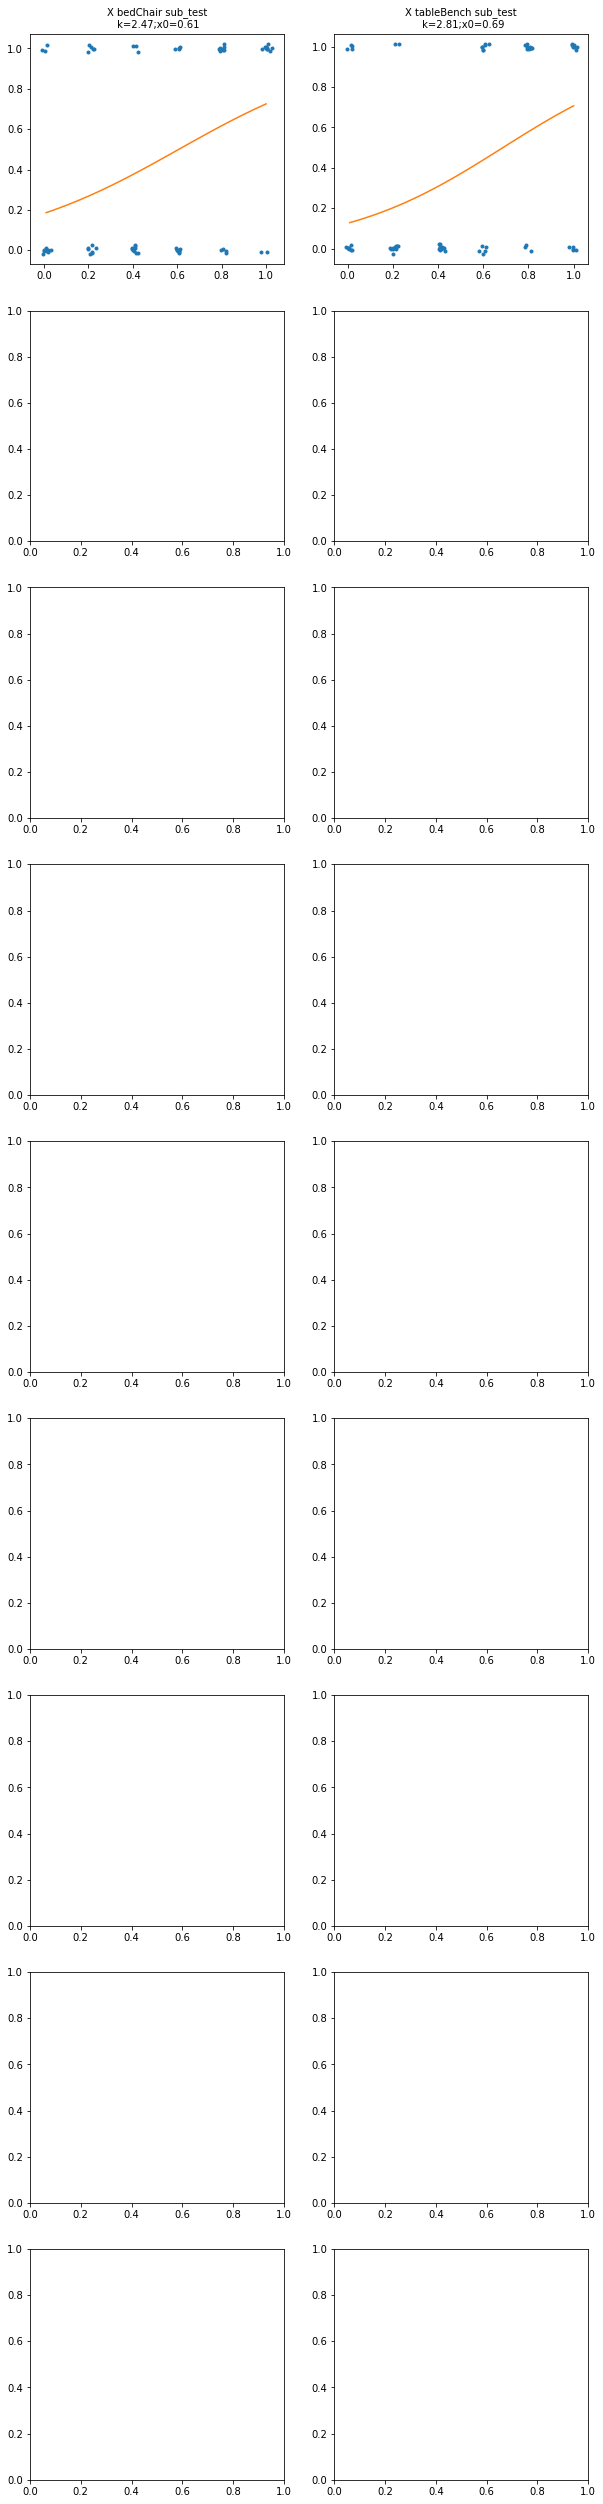

In [461]:
# tableBench[tableBench['Image'] == 11]['response']

import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/realtime/javascript/data/")


def logit(subject,axis,ax,which_subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })

    tableBench=resp.loc[resp['category'] == axis]
    if len(tableBench)==0:
        return None,None,None,None
    _x=np.asarray(tableBench['Image'])
    X_dict={0:1,1:21,2:41,3:60,4:80,5:100,6:1,7:21,8:41,9:60,10:80,11:100}
    x=[]
    for _ in _x:
        x.append(X_dict[_])
    y=np.asarray(tableBench['response'])
    xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
    xy=xy[:,xy[0,:].argsort()]
    #xy[1,:]=2-xy[1,:]
    methodFlag="method1"
    if methodFlag=="method1":
        # method 1: use original datapoints for regression
        x=xy[0,:]
        y=xy[1,:]-1
        x=x/100
    else:
        # method 2: use frequency of choices for regression
        prob=[]
        for i in [1,21,41,60,80,100]:
            _prob=np.mean(xy[1,xy[0]==i])
            #print(xy[1,xy[0]==i])
            #print(_prob,end='\n\n')
            prob.append(_prob)
        x=np.asarray([1,21,41,60,80,100], dtype=np.float128)/100
        y=np.asarray(prob)-1
    
    morph1acc=round(np.mean(1-y[x==0.01]),3)
    morph21acc=round(np.mean(1-y[x==0.21]),3)
    morph80acc=round(np.mean(y[x==0.80]),3)
    morph100acc=round(np.mean(y[x==1]),3)
#     print("morph 1 acc=",morph1acc)
#     print("morph 21 acc=",morph21acc)
#     print("morph 80 acc=",morph80acc)
#     print("morph 100 acc=",morph100acc)
    if morph1acc>0.8 and morph100acc>0.8:
        title='✓ '
        exclusion="✓"
    else:
        title='X '
        exclusion="X"
    try: 
        def f(x, k, x0):
            return 1 / (1. + np.exp(-k * (x - x0)))
        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)
#         fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if methodFlag=="method1":
            _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        else:
            _=ax.plot(x,y, 'o')
        _=ax.plot(x_plot, y_fit, '-')

        if len(tableBench)==72:
            title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                             )
        else:
            title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                              len(tableBench)
                                             )
            exclusion='X'
            
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y
    except:
        title="X "
        exclusion="X"
        k,x0=None,None
        
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        if len(tableBench)==72:
            title=title+"{} sub_{}".format(axis,
                                           which_subject #(subject.split("_")[1]).split(".")[0],
                                             )
        else:
            title=title+"{} sub_{}\n dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              len(tableBench)
                                             )
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return (morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)


def checkVersion(subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })
    axes={'bedChair':'horizontal', 'benchBed':'vertical', 'chairBench':'diagonal'}
    for axis in ['bedChair', 'benchBed', 'chairBench']:
        data=resp.loc[resp['category'] == axis]
        if len(data)>0:
            return axes[axis]
    
    
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

subject="catPer_O7JER.txt"
subject="catPer_ARZEZGD9TYK3Q.txt"
axis="bedTable" # bedChair tableBench; benchBed chairTable; chairBench bedTable

versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(9,2, figsize=(10, 5*9))
axis=versionDict[version][0]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0,0],"test")
axis=versionDict[version][1]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0,1],"test")

# scale it up to all subjects

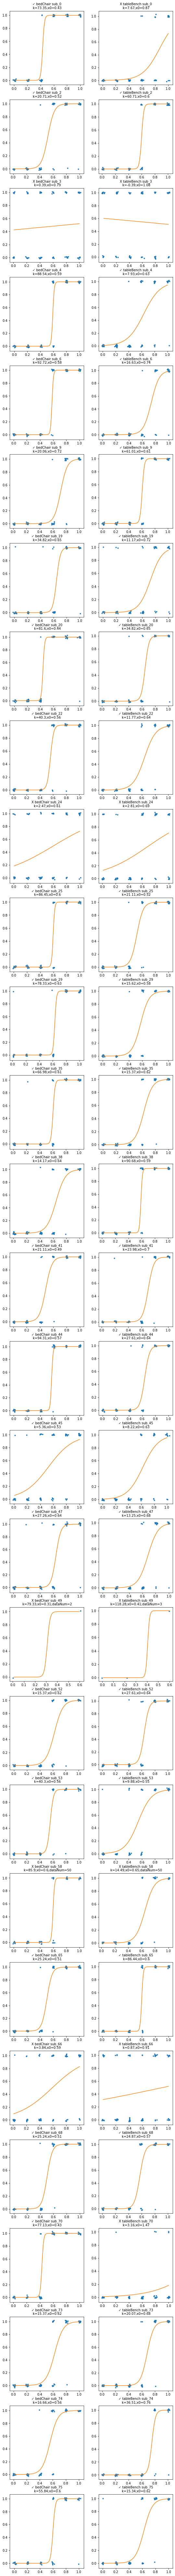

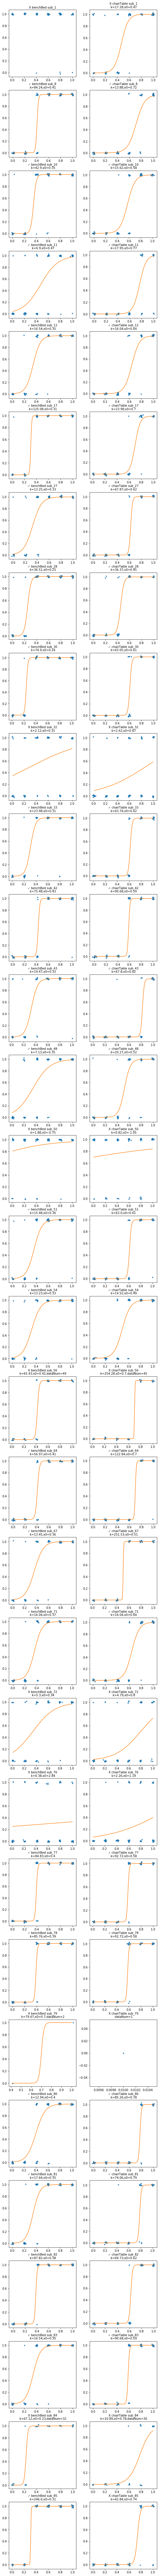

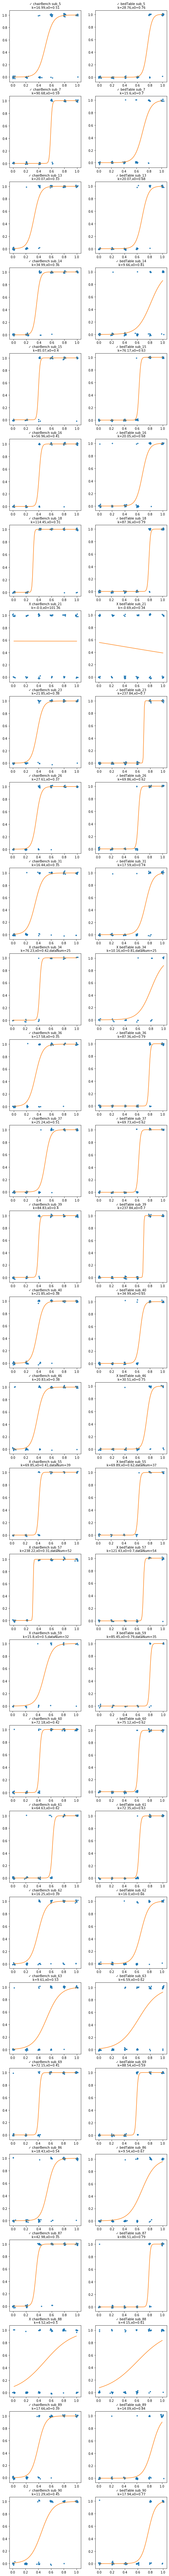

In [462]:
import glob
files=glob.glob("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/realtime/javascript/data/*.txt")
subjects=[]
morph1acc_bedChairC, morph21acc_bedChairC, morph80acc_bedChairC, morph100acc_bedChairC=[],[],[],[]
morph1acc_tableBenchC, morph21acc_tableBenchC, morph80acc_tableBenchC, morph100acc_tableBenchC=[],[],[],[]
versions=[]
for _ in files:
    subject=_.split("/")[-1]
    subjects.append(subject)
    version=checkVersion(subject)
    versions.append(version)

# ['bedChair', 'tableBench', 'benchBed', 'chairTable', 'chairBench', 'bedTable']

morph1acc={}
morph100acc={}
kDict={}
x0Dict={}
exclusion={}
# create empty dataframe to accumulate data
metadata = pd.DataFrame(columns=['subject', 'which_subject', 'version', 'axis', 'morph1acc', 'morph21acc', 'morph80acc', 'morph100acc', 'k', 'x0', 'exclusion','x','y'])

for curr_version in ['horizontal', 'vertical', 'diagonal']: #curr_version is the three versions, can also be list(versionDict.keys()):
    curr_sub=0 #curr_sub is used to change the figure axis for example: [curr_sub,0] [curr_sub,1]
    which_subject_list=np.where(np.asarray(versions)==curr_version)[0] #which_subject_list is list of ID (e.g. the 1st and 3rd of subject belongs to curr_version('horizontal'))
    f, ax = plt.subplots(len(which_subject_list),2, figsize=(9, len(which_subject_list)*10/2))
#     morph1acc[curr_version]={}
#     morph100acc[curr_version]={}
#     kDict[curr_version]={}
#     x0Dict[curr_version]={}
    for which_subject in which_subject_list:
        subject = subjects[which_subject]

        axis,morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y={},{},{},{},{},{},{},{},{},{}
        for curr_axis in range(2):
            axis[curr_axis]=versionDict[curr_version][curr_axis]
            (morph1acc[curr_axis], 
            morph21acc[curr_axis], 
            morph80acc[curr_axis], 
            morph100acc[curr_axis], 
            k[curr_axis], 
            x0[curr_axis], 
            exclusion[curr_axis], 
            x[curr_axis], 
            y[curr_axis])=logit(subject,axis[curr_axis],ax[curr_sub,curr_axis],which_subject)
        # write the data!
        if exclusion[0]=='X' or exclusion[1]=='X':
            exclusion[0]='X'
            exclusion[1]='X'
        for curr_axis in range(2):
            metadata = metadata.append({'subject':subject,
                                'which_subject':which_subject,
                                'version':curr_version,
                                'axis':axis[curr_axis],
                                'morph1acc':morph1acc[curr_axis],
                                'morph21acc':morph21acc[curr_axis],
                                'morph80acc':morph80acc[curr_axis],
                                'morph100acc':morph100acc[curr_axis],
                                'k':k[curr_axis],
                                'x0':x0[curr_axis],
                                'exclusion':exclusion[curr_axis],
                                'x':x[curr_axis],
                                'y':y[curr_axis]},
                               ignore_index=True)
        
#         axis=versionDict[curr_version][1]
#         morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y=logit(subject,axis,ax[curr_sub,1],which_subject)
#         # write the data!
#         metadata = metadata.append({'subject':subject,
#                             'which_subject':which_subject,
#                             'version':curr_version,
#                             'axis':axis,
#                             'morph1acc':morph1acc,
#                             'morph21acc':morph21acc,
#                             'morph80acc':morph80acc,
#                             'morph100acc':morph100acc,
#                             'k':k,
#                             'x0':x0,
#                             'exclusion':exclusion,
#                             'x':x,
#                             'y':y}, 
#                            ignore_index=True)
        
        
        curr_sub=curr_sub+1

# get the total subject number

In [463]:
print("total subject number={}".format(len(metadata)/2))
print("total horizontal subject number={}".format(len(metadata[metadata['version']=='horizontal'])/2))
print("total vertical subject number={}".format(len(metadata[metadata['version']=='vertical'])/2))
print("total diagonal subject number={}".format(len(metadata[metadata['version']=='diagonal'])/2),end='\n\n')

# exclusion
metadata_exclusion=metadata[metadata['exclusion']=='✓']
print("after exclusion total subject number={}".format(len(metadata_exclusion)/2))
print("after exclusion horizontal subject number={}".format(len(metadata_exclusion[metadata_exclusion['version']=='horizontal'])/2))
print("after exclusion vertical subject number={}".format(len(metadata_exclusion[metadata_exclusion['version']=='vertical'])/2))
print("after exclusion diagonal subject number={}".format(len(metadata_exclusion[metadata_exclusion['version']=='diagonal'])/2),end='\n\n')

# exclusion rate
print("total exclusion rate={}".format(len(metadata_exclusion)/2/
                                      (len(metadata)/2)))
print("horizontal exclusion rate={}".format(len(metadata_exclusion[metadata_exclusion['version']=='horizontal'])/2/
                                           (len(metadata[metadata['version']=='horizontal'])/2)))
print("vertical exclusion rate={}".format(len(metadata_exclusion[metadata_exclusion['version']=='vertical'])/2/
                                         (len(metadata[metadata['version']=='vertical'])/2)))
print("diagonal exclusion={}".format(len(metadata_exclusion[metadata_exclusion['version']=='diagonal'])/2/
                                    (len(metadata[metadata['version']=='diagonal'])/2)),end='\n\n')

# # exclusion proportion
# print("horizontalData exclusion rate=",len(horizontalData_exclusion)/len(horizontalData))
# print("verticalData exclusion rate=",len(verticalData_exclusion)/len(verticalData))
# print("diagonalData exclusion rate=",len(diagonalData_exclusion)/len(diagonalData))


total subject number=91.0
total horizontal subject number=29.0
total vertical subject number=32.0
total diagonal subject number=30.0

after exclusion total subject number=68.0
after exclusion horizontal subject number=22.0
after exclusion vertical subject number=23.0
after exclusion diagonal subject number=23.0

total exclusion rate=0.7472527472527473
horizontal exclusion rate=0.7586206896551724
vertical exclusion rate=0.71875
diagonal exclusion=0.7666666666666667



# test the end point accuracy for different version
# test the k value and x0 for different version

mean horizontal morph1acc endpoint accuracy with exclusion= 0.9886818181818184
mean horizontal morph100acc endpoint accuracy with exclusion= 0.9735454545454547
mean horizontal k with exclusion= 36.529975662660156
mean horizontal x0 with exclusion= 0.6069798204843374


mean vertical morph1acc endpoint accuracy with exclusion= 0.9801304347826089
mean vertical morph100acc endpoint accuracy with exclusion= 0.9837391304347828
mean vertical k with exclusion= 52.5540387663547
mean vertical x0 with exclusion= 0.4948713876474934


mean diagonal morph1acc endpoint accuracy with exclusion= 0.9855434782608697
mean diagonal morph100acc endpoint accuracy with exclusion= 0.965586956521739
mean diagonal k with exclusion= 51.290246734830035
mean diagonal x0 with exclusion= 0.5612307332784784




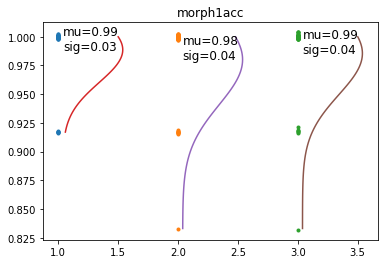

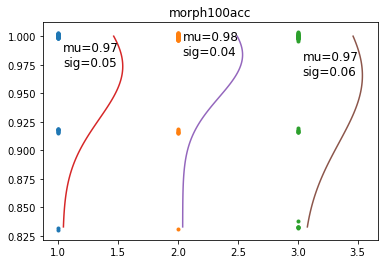

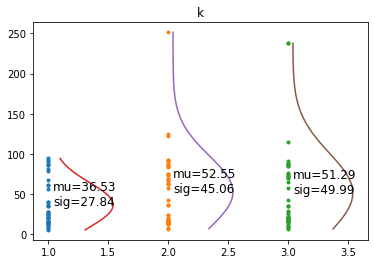

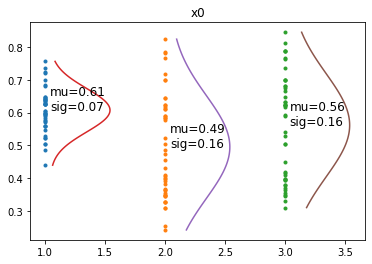

In [496]:
# end point accuracy for different version with exclusion

# horizontal
horizontalData=metadata[metadata['version']=='horizontal']
horizontalData_exclusion=horizontalData[horizontalData['exclusion']=='✓']
horizontalData_exclusion_morph1acc=horizontalData_exclusion['morph1acc']
print("mean horizontal morph1acc endpoint accuracy with exclusion=",np.mean(horizontalData_exclusion_morph1acc))
horizontalData_exclusion_morph100acc=horizontalData_exclusion['morph100acc']
print("mean horizontal morph100acc endpoint accuracy with exclusion=",np.mean(horizontalData_exclusion['morph100acc']))
print("mean horizontal k with exclusion=",np.mean(horizontalData_exclusion['k']))
print("mean horizontal x0 with exclusion=",np.mean(horizontalData_exclusion['x0']))
print('\n')

# vertical
verticalData=metadata[metadata['version']=='vertical']
verticalData_exclusion=verticalData[verticalData['exclusion']=='✓']
verticalData_exclusion_morph1acc=verticalData_exclusion['morph1acc']
print("mean vertical morph1acc endpoint accuracy with exclusion=",np.mean(verticalData_exclusion_morph1acc))
verticalData_exclusion_morph100acc=verticalData_exclusion['morph100acc']
print("mean vertical morph100acc endpoint accuracy with exclusion=",np.mean(verticalData_exclusion['morph100acc']))
print("mean vertical k with exclusion=",np.mean(verticalData_exclusion['k']))
print("mean vertical x0 with exclusion=",np.mean(verticalData_exclusion['x0']))
print('\n')

# diagonal
diagonalData=metadata[metadata['version']=='diagonal']
diagonalData_exclusion=diagonalData[diagonalData['exclusion']=='✓']
diagonalData_exclusion_morph1acc=diagonalData_exclusion['morph1acc']
print("mean diagonal morph1acc endpoint accuracy with exclusion=",np.mean(diagonalData_exclusion_morph1acc))
diagonalData_exclusion_morph100acc=diagonalData_exclusion['morph100acc']
print("mean diagonal morph100acc endpoint accuracy with exclusion=",np.mean(diagonalData_exclusion['morph100acc']))
print("mean diagonal k with exclusion=",np.mean(diagonalData_exclusion['k']))
print("mean diagonal x0 with exclusion=",np.mean(diagonalData_exclusion['x0']))
print('\n')

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def gaussian_fit(y=[1,2,3,4],x=1):
    y_values = np.linspace(min(y), max(y), 120)    
    mu=np.mean(y)
    sig=np.std(y)
    plt.text(x+0.04, mu, 'mu={0:.2f}\nsig={1:.2f}'.format(mu,sig), fontsize=12)
    plt.plot(x+0.04+0.5*gaussian(y_values, mu, sig),y_values)
    
    
plt.figure()
_=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),rand_jitter(horizontalData_exclusion_morph1acc),'.')
_=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),rand_jitter(verticalData_exclusion_morph1acc),'.')
_=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),rand_jitter(diagonalData_exclusion_morph1acc),'.')
gaussian_fit(y=horizontalData_exclusion_morph1acc,x=1)
gaussian_fit(y=verticalData_exclusion_morph1acc,x=2)
gaussian_fit(y=diagonalData_exclusion_morph1acc,x=3)
_=plt.title("morph1acc")

plt.figure()
_=plt.plot(1*np.ones(len(horizontalData_exclusion_morph100acc)),rand_jitter(horizontalData_exclusion_morph100acc),'.')
_=plt.plot(2*np.ones(len(verticalData_exclusion_morph100acc)),rand_jitter(verticalData_exclusion_morph100acc),'.')
_=plt.plot(3*np.ones(len(diagonalData_exclusion_morph100acc)),rand_jitter(diagonalData_exclusion_morph100acc),'.')
gaussian_fit(y=horizontalData_exclusion_morph100acc,x=1)
gaussian_fit(y=verticalData_exclusion_morph100acc,x=2)
gaussian_fit(y=diagonalData_exclusion_morph100acc,x=3)
_=plt.title("morph100acc")

plt.figure()
_=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),horizontalData_exclusion['k'],'.')
_=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),verticalData_exclusion['k'],'.')
_=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),diagonalData_exclusion['k'],'.')
gaussian_fit(y=horizontalData_exclusion['k'],x=1)
gaussian_fit(y=verticalData_exclusion['k'],x=2)
gaussian_fit(y=diagonalData_exclusion['k'],x=3)
_=plt.title("k")

plt.figure()
_=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),horizontalData_exclusion['x0'],'.')
_=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),verticalData_exclusion['x0'],'.')
_=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),diagonalData_exclusion['x0'],'.')
gaussian_fit(y=horizontalData_exclusion['x0'],x=1)
gaussian_fit(y=verticalData_exclusion['x0'],x=2)
gaussian_fit(y=diagonalData_exclusion['x0'],x=3)
_=plt.title("x0")



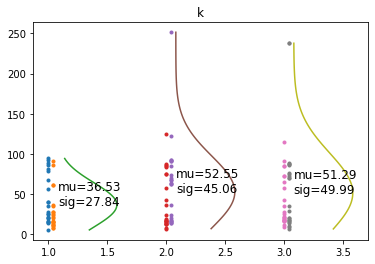

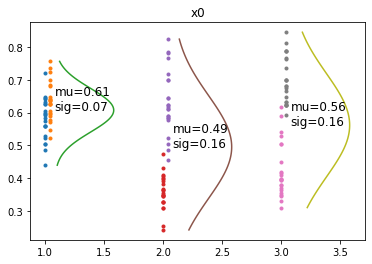

In [513]:
def gaussian_fit(y=[1,2,3,4],x=1):
    y_values = np.linspace(min(y), max(y), 120)    
    mu=np.mean(y)
    sig=np.std(y)
    plt.text(x+0.08, mu, 'mu={0:.2f}\nsig={1:.2f}'.format(mu,sig), fontsize=12)
    plt.plot(x+0.08+0.5*gaussian(y_values, mu, sig),y_values)
    
def plot_two_axes(horizontalData_exclusion,version='horizontal',offset=1,parameter='k'):
    horizontalData_exclusion_axis0=horizontalData_exclusion[horizontalData_exclusion['axis']==versionDict[version][0]]
    horizontalData_exclusion_axis1=horizontalData_exclusion[horizontalData_exclusion['axis']==versionDict[version][1]]
    _=plt.plot(offset*np.ones(len(horizontalData_exclusion_axis0)),horizontalData_exclusion_axis0[parameter],'.')
    _=plt.plot(0.04+offset*np.ones(len(horizontalData_exclusion_axis0)),horizontalData_exclusion_axis1[parameter],'.')
    gaussian_fit(y=horizontalData_exclusion[parameter],x=offset)


plt.figure()
plot_two_axes(horizontalData_exclusion,version='horizontal',offset=1,parameter='k')
plot_two_axes(verticalData_exclusion,version='vertical',offset=2,parameter='k')
plot_two_axes(diagonalData_exclusion,version='diagonal',offset=3,parameter='k')
_=plt.title("k")


plt.figure()
plot_two_axes(horizontalData_exclusion,version='horizontal',offset=1,parameter='x0')
plot_two_axes(verticalData_exclusion,version='vertical',offset=2,parameter='x0')
plot_two_axes(diagonalData_exclusion,version='diagonal',offset=3,parameter='x0')
_=plt.title("x0")


# plt.figure()
# _=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),horizontalData_exclusion['x0'],'.')
# _=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),verticalData_exclusion['x0'],'.')
# _=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),diagonalData_exclusion['x0'],'.')
# gaussian_fit(y=horizontalData_exclusion['x0'],x=1)
# gaussian_fit(y=verticalData_exclusion['x0'],x=2)
# gaussian_fit(y=diagonalData_exclusion['x0'],x=3)
# _=plt.title("x0")



# plot the mean of version:

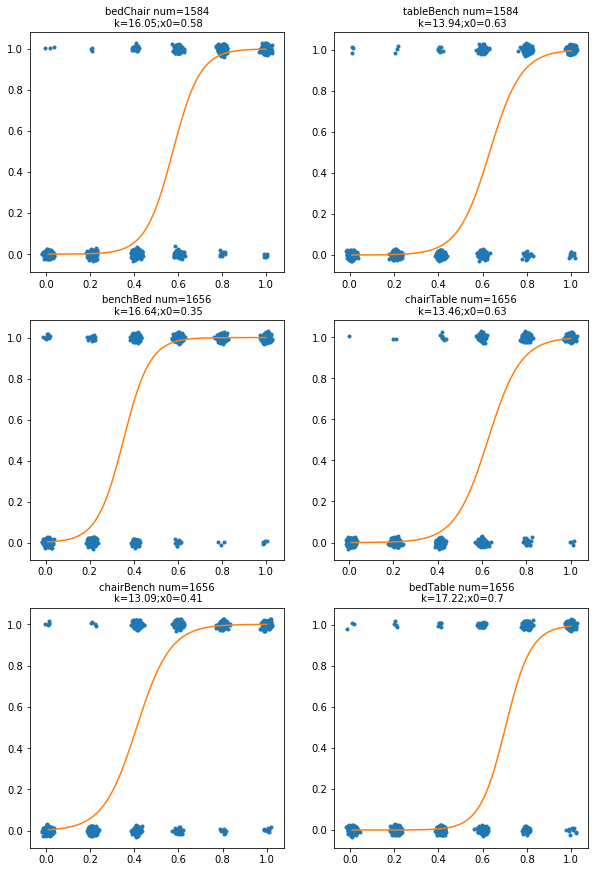

In [465]:
def f(x, k, x0):
    return 1 / (1. + np.exp(-k * (x - x0)))


# horizontalData=metadata[metadata['version']=='horizontal']
# horizontalData_exclusion=horizontalData[horizontalData['exclusion']=='✓']

fig, ax = plt.subplots(3, 2, figsize=(10, 5*3))
for curr_version_id,curr_version in enumerate(['horizontal', 'vertical', 'diagonal']):
    Data=metadata[metadata['version']==curr_version]
    Data_exclusion=Data[Data['exclusion']=='✓']
    for curr_axis in range(2):
        Data_exclusion_axis=Data_exclusion[Data_exclusion['axis']==versionDict[curr_version][curr_axis]]
        x=[]
        for _x in list(Data_exclusion_axis['x']):
            x=x+list(_x)
        y=[]
        for _y in list(Data_exclusion_axis['y']):
            y=y+list(_y)

        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)

        _=ax[curr_version_id,curr_axis].plot(rand_jitter(x), rand_jitter(y), '.')
        _=ax[curr_version_id,curr_axis].plot(x_plot, y_fit, '-')

        title="{} num={}\n k={};x0={}".format(versionDict[curr_version][curr_axis],
                                              len(x),
                                          round(k, 2),
                                          round(x0, 2),
                                         )



        _=ax[curr_version_id,curr_axis].set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})


In [466]:
# metadata_exclusion=metadata[metadata['exclusion']=='✓']

# plt.figure()
# _=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),rand_jitter(horizontalData_exclusion_morph1acc),'.')
# _=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),rand_jitter(verticalData_exclusion_morph1acc),'.')
# _=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),rand_jitter(diagonalData_exclusion_morph1acc),'.')
# _=plt.title("morph1acc")

# plt.figure()
# _=plt.plot(1*np.ones(len(horizontalData_exclusion_morph100acc)),rand_jitter(horizontalData_exclusion_morph100acc),'.')
# _=plt.plot(2*np.ones(len(verticalData_exclusion_morph100acc)),rand_jitter(verticalData_exclusion_morph100acc),'.')
# _=plt.plot(3*np.ones(len(diagonalData_exclusion_morph100acc)),rand_jitter(diagonalData_exclusion_morph100acc),'.')
# _=plt.title("morph100acc")

# plt.figure()
# _=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),horizontalData_exclusion['k'],'.')
# _=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),verticalData_exclusion['k'],'.')
# _=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),diagonalData_exclusion['k'],'.')
# _=plt.title("k")

# plt.figure()
# _=plt.plot(1*np.ones(len(horizontalData_exclusion_morph1acc)),horizontalData_exclusion['x0'],'.')
# _=plt.plot(2*np.ones(len(verticalData_exclusion_morph1acc)),verticalData_exclusion['x0'],'.')
# _=plt.plot(3*np.ones(len(diagonalData_exclusion_morph1acc)),diagonalData_exclusion['x0'],'.')
# _=plt.title("x0")



In [467]:
# # t test
# from scipy.stats import ttest_ind
# result=ttest_ind(Non_diagonal_data,diagonal_data)


# prevent subjects to participate when they already have
https://blog.mturk.com/tutorial-best-practices-for-managing-workers-in-follow-up-surveys-or-longitudinal-studies-4d0732a7319b

In [468]:
csv_subjects = pd.DataFrame(columns=["Worker ID", "UPDATE-Completed My Survey Already"])
for subject in subjects:
    #print(subject.split(".")[0][7:])
    WorkerID=subject.split(".")[0][7:]
    csv_subjects=csv_subjects.append({"Worker ID":WorkerID,
                                      "UPDATE-Completed My Survey Already":1
                                    },ignore_index=True)
csv_subjects.to_csv('./CompletedMySurveyAlready.csv')
csv_subjects

,Worker ID,UPDATE-Completed My Survey Already
0,A21EZISIJ3JPSW,1
1,A3760PCQD2MPIO,1
2,A2O2Q0LVWOWJ1G,1
3,A53VYIFCCASOA,1
4,A36H3PO6JZD414,1
...,...,...
86,AMX5R6NLYNA2K,1
87,A22KRF782ELLB0,1
88,ALCVGNUURF8LQ,1
89,A26UAJWMMNN351,1


$$f(x)=\frac{1}{1+e^{-k\left(x-x_{0}\right)}}$$

In [439]:
# import numpy as np
# import scipy.optimize as opt
# import matplotlib.pyplot as plt
# %matplotlib inline
# def f(x, k, x0):
#     return 1 / (1. + np.exp(-k * (x - x0)))

# #tableBench axis
# tableBench=resp.loc[resp['category'] == 'bedChair']
# tableBench=tableBench[tableBench['response'] != "NaN"]
# _x=np.asarray(tableBench['Image'])
# X_dict={0:1,1:21,2:41,3:60,4:80,5:100,6:1,7:21,8:41,9:60,10:80,11:100}
# x=[]
# for _ in _x:
#     x.append(X_dict[_])

# y=np.asarray(tableBench['response'])
# # for curr_trial in range(len(tableBench['response']'])):
# #     if tableBench['response'].iloc[curr_trial]=="['right']":
# #         if tableBench['button_right'].iloc[curr_trial]=="Table": #  1 0.95 0.8 0.2 0.05 0
# #             _y=1
# #         else:
# #             _y=0
# #     elif tableBench['key_resp.keys'].iloc[curr_trial]=="['left']":
# #         if tableBench['button_left'].iloc[curr_trial]=="Table":
# #             _y=1
# #         else:
# #             _y=0
# #     y.append(_y)
# # y=np.asarray(y)

# xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
# xy=xy[:,xy[0,:].argsort()]
# xy[1,:]=2-xy[1,:]


# # method 1: use original datapoints for regression
# x=xy[0,:]
# y=xy[1,:]
# x=x/100

# # method 2: use frequency of choices for regression
# # prob=[]
# # for i in [1,21,41,60,80,100]:
# #     _prob=np.mean(xy[1,xy[0]==i])
# #     prob.append(_prob)
# # x=np.asarray([1,21,41,60,80,100], dtype=np.float128)/100
# # y=np.asarray(prob)


# # fit and plot the curve
# (k,x0), _ = opt.curve_fit(f, x, y)
# print('k=',k)
# print('x0=',x0)
# n_plot=100
# x_plot = np.linspace(min(x), max(x), n_plot)
# y_fit = f(x_plot, k,x0)
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# _=ax.plot(x, y, 'o')
# _=ax.plot(x_plot, y_fit, '-')

In [2]:
# _=np.empty((6,12))
# _[:]=None
# for i in range(6):
#     for j in range(12):
#         _[i][j]=y[i*6+j]
# plt.plot(np.mean(_,axis=1))
# _
import numpy as np
a=[495.11,425.48,306.67,501.70,454.51,368.39]
np.std(a)

69.37275762141793

/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


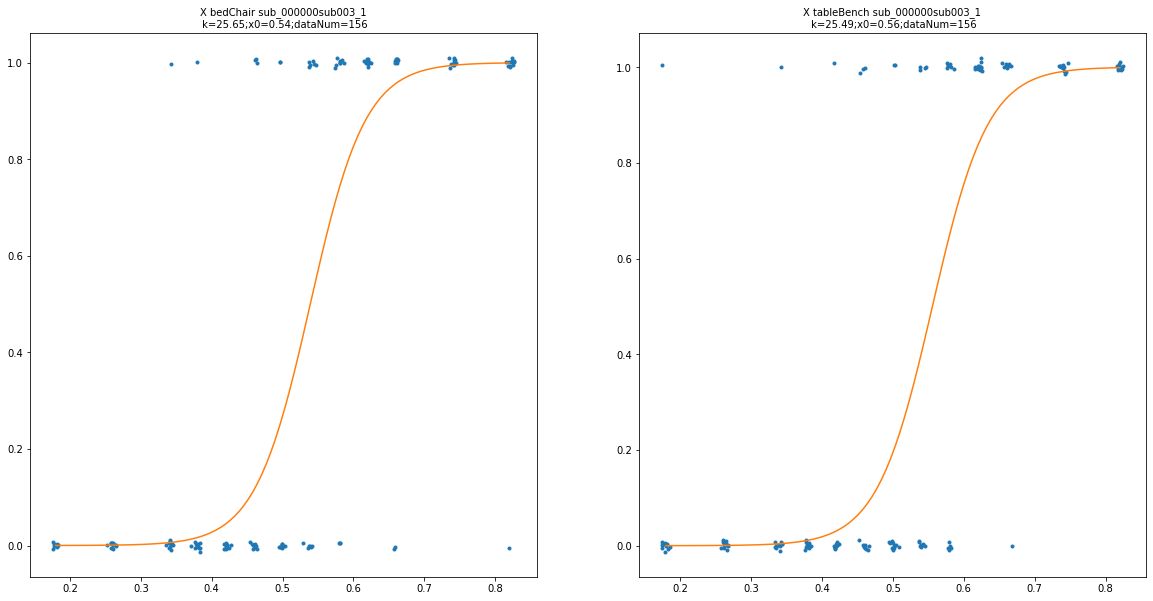

In [3]:

# design 13  and random button
import pandas as pd
import os
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def logit(subject,axis,ax,which_subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        10:"ButtonLeft",
        11:"ButtonRight"
        })

    tableBench=resp.loc[resp['category'] == axis]
    if len(tableBench)==0:
        return None,None,None,None
    _x=np.asarray(tableBench['Image'])
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    # X_dict={0:18, 1:26, 2:34, 3:42, 4:50, 5:58, 6:66, 7:74, 8:82, 9:18, 10:26, 11:34, 12:42, 13:50, 14:58, 15:66, 16:74, 17:82}
    X_dict={0:18,1:26,2:34,3:38,4:42,5:46,6:50,7:54,8:58,9:62,10:66,11:74,12:82,13:18,14:26,15:34,16:38,17:42,18:46,19:50,20:54,21:58,22:62,23:66,24:74,25:82}
    x=[]
    for _ in _x:
        x.append(X_dict[_])
    y=np.asarray(tableBench['response'])
    # according to whether bottonLeft is Bed or Table, resave the response
    y_=[]
    if 'bed' in axis:
        button_good=list(tableBench['ButtonLeft']=="Bed")
    else:
        button_good=list(tableBench['ButtonLeft']=="Table")
    for i,j in enumerate(button_good):
        if j:
            y_.append(y[i])
        else:
            if y[i]==1:
                y_.append(2)
            else:
                y_.append(1)
    y=np.asarray(y_)

    xy=np.concatenate((np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)), axis=0)
    xy=xy[:,xy[0,:].argsort()]
    #xy[1,:]=2-xy[1,:]
    methodFlag="method1"
    if methodFlag=="method1":
        # method 1: use original datapoints for regression
        x=xy[0,:]
        y=xy[1,:]-1
        x=x/100
    else:
        # method 2: use frequency of choices for regression
        pass
        # prob=[]
        # for i in [18, 26, 34, 42, 50, 58, 66, 74, 82]:
        #     _prob=np.mean(xy[1,xy[0]==i])
        #     #print(xy[1,xy[0]==i])
        #     #print(_prob,end='\n\n')
        #     prob.append(_prob)
        # x=np.asarray([18, 26, 34, 42, 50, 58, 66, 74, 82], dtype=np.float128)/100
        # y=np.asarray(prob)-1
    
    morph1acc=round(np.mean(1-y[x==0.01]),3)
    morph21acc=round(np.mean(1-y[x==0.21]),3)
    morph80acc=round(np.mean(y[x==0.80]),3)
    morph100acc=round(np.mean(y[x==1]),3)
    # print("morph 1 acc=",morph1acc)
    # print("morph 21 acc=",morph21acc)
    # print("morph 80 acc=",morph80acc)
    # print("morph 100 acc=",morph100acc)
    if morph1acc>0.8 and morph100acc>0.8:
        title='✓ '
        exclusion="✓"
    else:
        title='X '
        exclusion="X"
    try: 
        def f(x, k, x0):
            return 1 / (1. + np.exp(-k * (x - x0)))
        # fit and plot the curve
        (k,x0), _ = opt.curve_fit(f, x, y)
        n_plot=100
        x_plot = np.linspace(min(x), max(x), n_plot)
        y_fit = f(x_plot, k,x0)
        # fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if methodFlag=="method1":
            _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        else:
            _=ax.plot(x,y, 'o')
        _=ax.plot(x_plot, y_fit, '-')

        if len(tableBench)==72:
            title=title+"{} sub_{}\n k={};x0={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                             )
        else:
            title="X {} sub_{}\n k={};x0={};dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              round(k, 2),
                                              round(x0, 2),
                                              len(tableBench)
                                             )
            exclusion='X'
            
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y
    except:
        title="X "
        exclusion="X"
        k,x0=None,None
        
        _=ax.plot(rand_jitter(x), rand_jitter(y), '.')
        if len(tableBench)==72:
            title=title+"{} sub_{}".format(axis,
                                           which_subject #(subject.split("_")[1]).split(".")[0],
                                             )
        else:
            title=title+"{} sub_{}\n dataNum={}".format(axis,
                                              which_subject, #(subject.split("_")[1]).split(".")[0],
                                              len(tableBench)
                                             )
        _=ax.set_title(title,fontdict={'fontsize': 10, 'fontweight': 'medium'})
        
        return (morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)


def checkVersion(subject):
    resp=pd.read_csv('./'+subject, sep='\t', lineterminator='\n',header=None)
    resp=resp.rename(columns={
        0:"workerid",
        1:"this_trial",
        2:"Image",
        3:"ImagePath",
        4:"category",
        5:"imageStart",
        6:"imageEnd",
        7:"response",
        8:"responseTime",
        9:"currentTime",
        })
    axes={'bedChair':'horizontal', 'benchBed':'vertical', 'chairBench':'diagonal'}
    for axis in ['bedChair', 'benchBed', 'chairBench']:
        data=resp.loc[resp['category'] == axis]
        if len(data)>0:
            return axes[axis]
    
    
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# os.chdir("/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/sub002/ses1/catPer")
# subject="catPer_000000sub002_1.txt"

# sub="sub002"
# ses="ses1"


# sub="sub001"
# ses="ses1"


# sub="sub002"
# ses="ses6"

# if ses=="ses6" or ses=="ses5":
#     catPerSession=2
# else:
#     catPerSession=1
# os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/{sub}/{ses}/catPer")
# subject=f"catPer_000000{sub}_{catPerSession}.txt"

# subject="catPer_123456subTest5.txt"
# subject="catPer_123456subTest6.txt"
# subject="catPer_123456sub0jeff.txt"
# subject="catPer_123456subTest7.txt"

# os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/catPer/data/")

sub="000000sub003_1" #12345subTest11 12345subShmily
subject=f"catPer_{sub}.txt"
os.chdir(f"/Users/kailong/Desktop/rtEnv/rtSynth_rt/subjects/{sub[6:].split('_')[0]}/ses{sub[6:].split('_')[1]}/catPer")

versionDict={'horizontal':['bedChair', 'tableBench'],
            'vertical':['benchBed', 'chairTable'],
            'diagonal':['chairBench', 'bedTable']}
version=checkVersion(subject)


f, ax = plt.subplots(1,2, figsize=(20, 10))
axis=versionDict[version][0]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[0],sub)
axis=versionDict[version][1]
(morph1acc, morph21acc, morph80acc, morph100acc,k,x0,exclusion,x,y)=logit(subject,axis,ax[1],sub)



In [57]:


from __future__ import print_function, division
import traceback,time
# try:

import sys,os
if 'watts' in os.getcwd():
    sys.path.append("/home/watts/Desktop/ntblab/kailong/rtSynth_rt/")
elif 'kailong' in os.getcwd():
    sys.path.append("/Users/kailong/Desktop/rtEnv/rtSynth_rt/")
elif 'milgram' in os.getcwd():
    sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')

import os
from psychopy import visual, event, core, logging, gui, data, monitors
from psychopy.hardware.emulator import launchScan, SyncGenerator
from PIL import Image
import string
import numpy as np
import pandas as pd
import pylink
import argparse
import rtCommon.fmrisim as sim
from rtCommon.cfg_loading import mkdir,cfg_loading

# imcode:
# A: bed
# B: Chair
# C: table
# D: bench
alpha = string.ascii_uppercase


argParser = argparse.ArgumentParser()
argParser.add_argument('--config', '-c', default='sub002.ses3.toml', type=str, help='experiment file (.json or .toml)')
argParser.add_argument('--run', '-r', default='1', type=str, help='current run')
argParser.add_argument('--trying', default=False, action='store_true',
                        help='Use unsecure non-encrypted connection')
args = argParser.parse_args("")

cfg = cfg_loading(args.config)
sub = cfg.subjectName
run = int(args.run)  # 1
TR=cfg.TR
cfg.dicom_dir

toml filename=/Users/kailong/Desktop/rtEnv/rtSynth_rt/projects/rtSynth_rt/conf/sub002.ses3.toml


'/gpfs/milgram/project/realtime/DICOM/20210512.rtSynth_sub002.rtSynth_sub002/'

In [4]:


from __future__ import print_function, division
import traceback,time
# try:

import sys,os
if 'watts' in os.getcwd():
    sys.path.append("/home/watts/Desktop/ntblab/kailong/rtSynth_rt/")
elif 'kailong' in os.getcwd():
    sys.path.append("/Users/kailong/Desktop/rtEnv/rtSynth_rt/")
elif 'milgram' in os.getcwd():
    sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')

import os
from psychopy import visual, event, core, logging, gui, data, monitors
from psychopy.hardware.emulator import launchScan, SyncGenerator
from PIL import Image
import string
import numpy as np
import pandas as pd
import pylink
import argparse
import rtCommon.fmrisim as sim
from rtCommon.cfg_loading import mkdir,cfg_loading

# imcode:
# A: bed
# B: Chair
# C: table
# D: bench
alpha = string.ascii_uppercase


argParser = argparse.ArgumentParser()
argParser.add_argument('--config', '-c', default='pilot_sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
argParser.add_argument('--run', '-r', default='1', type=str, help='current run')
argParser.add_argument('--trying', default=False, action='store_true',
                        help='Use unsecure non-encrypted connection')
args = argParser.parse_args("")

cfg = cfg_loading(args.config)
sub = cfg.subjectName
run = int(args.run)  # 1
TR=cfg.TR


conda env=rtcloud
toml filename=/Users/kailong/Desktop/rtEnv/rtSynth_rt/projects/rtSynth_rt/conf/pilot_sub001.ses1.toml


In [15]:
sys.path.append('/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading
behaviorDataLoading(cfg,2)

KeyError: 'switchButtonOrientation'

In [47]:
curr_run=2
behav_data = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{2}.csv")

# the item(imcode) colume of the data represent each image in the following correspondence
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}

# When the imcode code is "A", the correct response should be '1', "B" should be '2'
correctResponseDict={
'A': 1,
'B': 2,
'C': 1,
'D': 2}

SwitchCorrectResponseDict={
'A': 2,
'B': 1,
'C': 2,
'D': 1}

# 由于每次保存按钮的时候所保存的这个flag（switchButtonOrientation）对应的是下一个trial的switchButtonOrientation，
# 因此采用把switchButtonOrientation往前推一个的方法纠正。  中文
switchButtonOrientation = [None] + list(behav_data['switchButtonOrientation'])
switchButtonOrientation = switchButtonOrientation[:-1]
behav_data['switchButtonOrientation'] = switchButtonOrientation
# extract the labels which is selected by the subject and coresponding TR and time
behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item', 'switchButtonOrientation']] # the TR, the real time it was presented, 

# 为了处理 情况 A.被试的反应慢了一个TR，或者 B.两个按钮都被按了(这种情况下按照第二个按钮处理)
# 现在的问题是”下一个TR“可能超过了behav_data的长度
# this for loop is to deal with the situation where Resp is late for 1 TR, or two buttons are pressed. 
# when Resp is late for 1 TR, set the current Resp as the later Response.
# when two buttons are pressed, set the current Resp as the later Response because the later one should be the real choice
for curr_trial in range(behav_data.shape[0]):
    if behav_data['Item'].iloc[curr_trial]  in ["A","B","C","D"]:
        if curr_trial+1<behav_data.shape[0]: # 为了防止”下一个TR“超过behav_data的长度  中文
            if behav_data['Resp'].iloc[curr_trial+1] in [1.0,2.0]:
                behav_data['Resp'].iloc[curr_trial]=behav_data['Resp'].iloc[curr_trial+1]


behav_data=behav_data.dropna(subset=['Item'])

# check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
isCorrect=[]
for curr_trial in range(behav_data.shape[0]):
    if behav_data['switchButtonOrientation'].iloc[curr_trial]:
        isCorrect.append(SwitchCorrectResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
    else:
        isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])

print(f"behavior pressing accuracy for run {curr_run} = {np.mean(isCorrect)}")

behav_data['isCorrect']=isCorrect # merge the isCorrect clumne with the data dataframe
behav_data['subj']=[cfg.subjectName for i in range(len(behav_data))]
behav_data['run_num']=[int(curr_run) for i in range(len(behav_data))]
behav_data=behav_data[behav_data['isCorrect']] 

behavior pressing accuracy for run 2 = 1.0


In [48]:
behav_data

,TR,image_on,Resp,Item,switchButtonOrientation,isCorrect,subj,run_num
3,9,18.010818,2.0,D,0.0,True,pilot_sub001,2
5,11,22.011775,2.0,C,1.0,True,pilot_sub001,2
7,13,26.011719,1.0,B,1.0,True,pilot_sub001,2
9,15,30.011898,2.0,D,0.0,True,pilot_sub001,2
12,18,36.010757,1.0,B,1.0,True,pilot_sub001,2
15,21,42.011199,2.0,A,1.0,True,pilot_sub001,2
17,23,46.014266,1.0,C,0.0,True,pilot_sub001,2
21,27,54.011830,2.0,D,0.0,True,pilot_sub001,2
24,30,60.011443,1.0,A,0.0,True,pilot_sub001,2


In [34]:
behav_data['switchButtonOrientation'].iloc[-1]

0.0

In [27]:
for i in range(10):
    if behav_data['switchButtonOrientation'].iloc[i]:
        print(i)

0
2
4
6
8
9


In [42]:
behav_data = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{2}.csv")


In [43]:
behav_data

,Unnamed: 0,Sub,Run,TR,Onset,Item,Change,CorrResp,Resp,RT,Acc,image_on,button_on,button_off,switchButtonOrientation
0,0,pilot_sub001,2,6,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,pilot_sub001,2,7,2,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2,pilot_sub001,2,8,4,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,3,pilot_sub001,2,9,6,D,0.0,NaN,2.0,0.581719,NaN,18.010818,19.027379,19.928711,0.0
4,4,pilot_sub001,2,10,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,5,pilot_sub001,2,11,10,C,0.0,NaN,2.0,0.699669,NaN,22.011775,23.044432,23.929376,1.0
6,6,pilot_sub001,2,12,12,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,7,pilot_sub001,2,13,14,B,0.0,NaN,1.0,0.532908,NaN,26.011719,27.029659,27.929418,1.0
8,8,pilot_sub001,2,14,16,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,9,pilot_sub001,2,15,18,D,0.0,NaN,2.0,0.715496,NaN,30.011898,31.028141,31.927973,0.0
